In [2]:
from google.colab import files
uploaded = files.upload()


Saving archive (29).zip to archive (29).zip


In [3]:
import zipfile

with zipfile.ZipFile("archive (29).zip", 'r') as zip_ref:
    zip_ref.extractall("diabetic_dna")


In [4]:
import os

for root, dirs, files in os.walk("diabetic_dna"):
    for file in files:
        if file.lower().endswith(".csv"):
            print(os.path.join(root, file))


diabetic_dna/dataset/SKRIPSI_Data_DM_DNA_Sequence.csv


In [5]:
import pandas as pd

df = pd.read_csv("diabetic_dna/dataset/SKRIPSI_Data_DM_DNA_Sequence.csv")
print(df.head())
print(df.columns)


                                            sequence  length class
0  AATAATTTGTGCACTTCAGAATATTCTACAATAATATATTATTTCC...    1010  DMT2
1  AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...    1010  DMT2
2  AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...    1013  DMT2
3  AGTTGGAGTCTCCAGGGATCAGGGTTCCAGGAACTCAGGATCTGCA...    1013  DMT2
4  AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...    1015  DMT2
Index(['sequence', 'length', 'class'], dtype='object')


In [6]:
print(df['class'].unique())

['DMT2' 'DMT1' 'NONDM']


In [7]:
df['label'] = df['class'].map({'DMT2': 0, 'DMT1': 1, 'NONDM': 2})

In [8]:
def kmers(sequence, k=6):
    return " ".join([sequence[i:i+k] for i in range(len(sequence) - k + 1)])

df['kmers'] = df['sequence'].apply(kmers)


In [9]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['kmers'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label']  # Ensures class balance in train/val
)


In [10]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("zhihan1996/DNA_bert_6")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [11]:
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors='tf'
)

val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors='tf'
)


In [12]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    tf.convert_to_tensor(train_labels)
)).batch(8)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    tf.convert_to_tensor(val_labels)
)).batch(8)


In [13]:
from transformers import TFBertForSequenceClassification

model = TFBertForSequenceClassification.from_pretrained(
    "zhihan1996/DNA_bert_6",
    num_labels=3,
    from_pt=True  # ✅ this loads PyTorch weights into TensorFlow model
)


pytorch_model.bin:   0%|          | 0.00/359M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
import tensorflow as tf

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


In [15]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=3)


Epoch 1/3
158/158 [==============================] - 230s 1s/step - loss: 0.8756 - accuracy: 0.6027 - val_loss: 0.8021 - val_accuracy: 0.6646
Epoch 2/3
158/158 [==============================] - 182s 1s/step - loss: 0.7842 - accuracy: 0.6630 - val_loss: 0.7276 - val_accuracy: 0.6867
Epoch 3/3
158/158 [==============================] - 182s 1s/step - loss: 0.6915 - accuracy: 0.7090 - val_loss: 0.6385 - val_accuracy: 0.7373


In [16]:
from sklearn.metrics import classification_report

# Get predictions
pred_logits = model.predict(val_dataset).logits
pred_labels = tf.argmax(pred_logits, axis=1).numpy()

# Classification report
print(classification_report(val_labels, pred_labels, target_names=['DMT2', 'DMT1', 'NONDM']))


40/40 [==============================] - 17s 338ms/step
              precision    recall  f1-score   support

        DMT2       0.62      0.57      0.60        89
        DMT1       1.00      0.17      0.29        29
       NONDM       0.77      0.89      0.83       198

    accuracy                           0.74       316
   macro avg       0.80      0.55      0.57       316
weighted avg       0.75      0.74      0.71       316



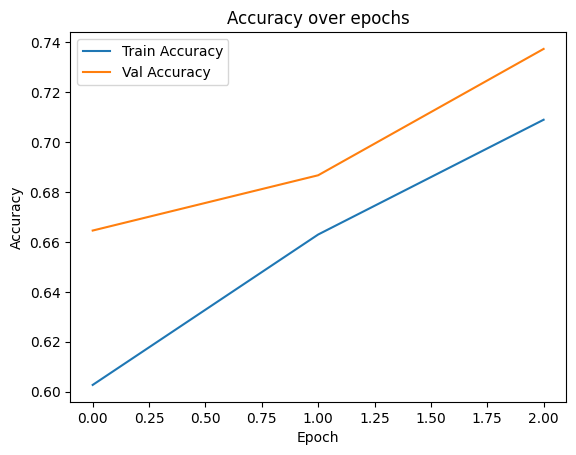

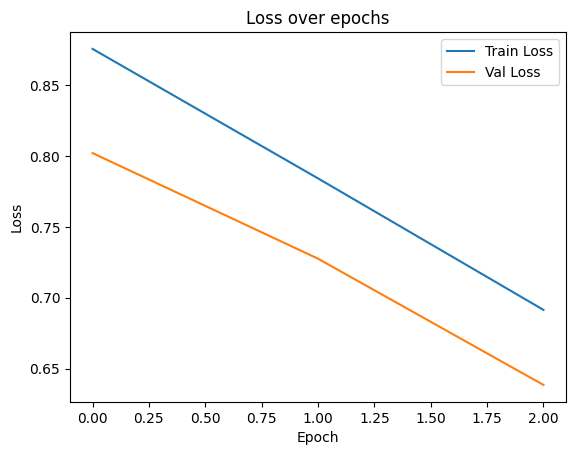

In [17]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [18]:
def predict_sequence(seq, k=6):
    kmer_seq = " ".join([seq[i:i+k] for i in range(len(seq) - k + 1)])
    enc = tokenizer(kmer_seq, return_tensors='tf', padding=True, truncation=True, max_length=512)
    output = model.predict(enc).logits
    pred_class = tf.argmax(output, axis=1).numpy()[0]
    return ['DMT2', 'DMT1', 'NONDM'][pred_class]
